<a href="https://colab.research.google.com/github/SDS-AAU/M3-2018/blob/master/notebooks/Hatespeech_LSTM_SDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a BiLSTM classifier
## With self-trained embeddings

In this notebook we are going to use our self-trained fastText embeddings to train a reccurent classifier model for the hatespeech problem from the M2 assignment.

![alt text](http://www.inf.ed.ac.uk/teaching/courses/tnlp/robot-reading.jpg)



*   We will first download and open the pretrained model
*   We will map our text inputs to their respective indices
*   We will construct a recurrent neural net architecture with an embedding layer
*   Finally, we'll frain the model (data in memory, no streaming needed, since it's small data)
*   Evaluate our results





In [0]:
# Install libraries that may not be present

%%capture 

!pip install gensim 

In [0]:
# Import the usual suspects

import pandas as pd
import numpy as np

# Surpress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Import plotting & nice style
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [0]:
# We'll import gensim for handling the fasttext model
from gensim.models import FastText

In [5]:
# We downlaod the model. And yes, it is a 776MB file!

!wget http://sds-datacrunch.aau.dk/public/model_toxic2.zip

--2018-11-07 10:14:56--  http://sds-datacrunch.aau.dk/public/model_toxic2.zip
Resolving sds-datacrunch.aau.dk (sds-datacrunch.aau.dk)... 192.38.56.127
Connecting to sds-datacrunch.aau.dk (sds-datacrunch.aau.dk)|192.38.56.127|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 814168249 (776M) [application/zip]
Saving to: ‘model_toxic2.zip’

model_toxic2.zip    100%[===================>] 776.45M  8.81MB/s    in 84s     

2018-11-07 10:16:21 (9.23 MB/s) - ‘model_toxic2.zip’ saved [814168249/814168249]



In [6]:
# Let's unzip

!unzip model_toxic2.zip

Archive:  model_toxic2.zip
  inflating: model_toxic.m           
  inflating: model_toxic.m.wv.vectors.npy  
  inflating: model_toxic.m.trainables.syn1neg.npy  
  inflating: model_fasttext.m        
  inflating: model_fasttext.m.wv.vectors.npy  
  inflating: model_fasttext.m.wv.vectors_vocab.npy  
  inflating: model_fasttext.m.wv.vectors_ngrams.npy  


In [0]:
# Loading the model

model_fasttext = FastText.load('model_toxic.m')

#### A short reminder about what we mean when we say model:

Remember that in this exercise we are training 2 things. First, we train an unsuprevised Fasttext model by passing text into gensim-fasstext. Then, we use this model (the embedding matrix) as a building block of the neural net to transform incoming words into word-vectors, that carry meaning.

![alt text](http://soberfish.co.uk/wp-content/uploads/2017/11/img_7688-1080x675.jpg)

Do you think, we could deploy an LSA or a like in a similar setup (perhaps without the recurrent component)

In [8]:
model_fasttext.wv.vectors.shape

(63124, 300)

In [9]:
!wget http://sds-datacrunch.aau.dk/public/hatespeech.p

--2018-11-07 10:16:58--  http://sds-datacrunch.aau.dk/public/hatespeech.p
Resolving sds-datacrunch.aau.dk (sds-datacrunch.aau.dk)... 192.38.56.127
Connecting to sds-datacrunch.aau.dk (sds-datacrunch.aau.dk)|192.38.56.127|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5609540 (5.3M) [text/x-pascal]
Saving to: ‘hatespeech.p’

hatespeech.p        100%[===================>]   5.35M  2.04MB/s    in 2.6s    

2018-11-07 10:17:01 (2.04 MB/s) - ‘hatespeech.p’ saved [5609540/5609540]



In [0]:
# extremely lazy loading from a pickle, stored when were training the embeddings

hatespeech = pd.read_pickle('hatespeech.p')

In [0]:
# Remove the "rt" (only preprocessing step, due to being lazy, mostly)

hatespeech['tokenized'] = hatespeech['tokenized'].map(lambda t: [x for x in t if x != 'rt'])

### Creating the embedding matrix

Now that we have loaded the model and the data that we are going to work with, we need to initialize the embedding matrix

In [0]:
# firtst, we ened to define the vocabulary to make a mapping dictionary

vocab = list(model_fasttext.wv.vocab.keys())

sidenote: there maybe somewhere in gensim a hidden function that makes whis step seem naive. But, honestly it's easy anough and works

In [0]:
# Create an empty dictionary and enter all words with their ids into it.

model_dict = {}

for word in vocab:
  model_dict[word] = model_fasttext.wv.vocab[word].index

In [0]:
# Map all words to their ids from the dictionary

hatespeech['sequences'] = hatespeech['tokenized'].map(lambda t: list(map(model_dict.get,t)))

In [0]:
# Filter out all instances of "None" (kind of the same what we just did with rt but using filter)

hatespeech['sequences'] = hatespeech['sequences'].apply(lambda t: list(filter(None, t)))

Something I'm not very proud of :(
However, the only "correct" soulution that I've seen and the simpler rewrites that I can think of right now are annoyingly hacky. In case you find a great and elegant solution, let me know

In [16]:
# the is (as very often) the word with index 0 and the one that doesn't really matter in terms of semantics
model_fasttext.wv.index2entity[0]

'the'

In [0]:
# We use that insight and manipulate it's vector to become a zero-vector.

model_fasttext.wv.vectors[0] = np.zeros(300,)

In [18]:
model_fasttext.wv.vectors[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [0]:
# Setting some parameters

word_vectors = model_fasttext.wv

MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 20

#### Let's start by creating the inputs

Inputs int neural nets are usually (we will stick to that here) of the same shape.
Our tweets are however of variable length. Therefore we are going to "pad" them up with zeros. 

To pad or not to pad

> Thank you for the quick answer. So after padding, how the library knows to ignore the padded values (and not to use them in the training).

> It doesn't know. But it learns to ignore them: in practice, sequence padding won't noticeably impact training. But if you're worried about it, you can always use batches of size 1. -François Chollet 





In [20]:
# Import sequence-padding (Thanks Keras)
import keras
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
# Creating our X's

X = pad_sequences(hatespeech['sequences'], maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

In [0]:
# Creating our y's (You are welcome to use Sklearn if you miss it)

y = keras.utils.to_categorical(hatespeech['class'], num_classes=3)

In [0]:
# Splitting the dataset into the Training set and Test set - old-school way

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [0]:
# Let's import som building blocks that we will need
from keras.layers import Dense, Input, CuDNNLSTM, LSTM, Embedding, Dropout, SpatialDropout1D, Bidirectional
from keras.models import Model 
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization


### Some explanation on the imported stuff

- CuDNNLSTM: NVIDIA CUDA® Deep Neural Network library (cuDNN) – fast LSTM implementation that runs only with Tensorflow backend (but that's kind of the usual thing to use these days)
- LSTM (standard LSTM - but we kind of have a faster version)
- Embedding: Our layer in which we will park our pre-trained vectors
- SpacialDropout1d (for killing one vector at a time)
- Bidirectional wrapper for our LSTM layer (basically it will force it to do everything 2 times - forwards and backwards)

### Let's build this network architecture:


In [0]:
# First the embedding layer


# model_fasttext.wv.vectors is just our preloaded fasttext model


wv_layer = Embedding(model_fasttext.wv.vectors.shape[0],
                     model_fasttext.wv.vectors.shape[1],
                     mask_zero=False,
                     weights=[model_fasttext.wv.vectors],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=True)

In [0]:
# Inputs

comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences = wv_layer(comment_input)

embedded_sequences = SpatialDropout1D(0.3)(embedded_sequences)

In [0]:
# biLSTM (only one layer with 128 neurons)

x = Bidirectional(CuDNNLSTM(128, return_sequences=False))(embedded_sequences)


# In case you don't have a GPU
#x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

In [0]:
# Output

x = Dropout(0.4)(x)
x = BatchNormalization()(x)
preds = Dense(3, activation='sigmoid')(x)

In [0]:
# build the model

model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# Let's pring out the model summary

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 300)           18937200  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               440320    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total para

In [31]:
# Let's train

hist = model.fit(X_train, y_train, validation_split=0.1,
                 epochs=5, batch_size=200, shuffle=True)

Train on 17843 samples, validate on 1983 samples
Epoch 1/5
17843/17843 [==============================] - 7s 410us/step - loss: 0.5404 - acc: 0.7520 - val_loss: 0.3134 - val_acc: 0.8921
Epoch 2/5
17843/17843 [==============================] - 4s 218us/step - loss: 0.2685 - acc: 0.9086 - val_loss: 0.2158 - val_acc: 0.9269
Epoch 3/5
17843/17843 [==============================] - 4s 219us/step - loss: 0.1994 - acc: 0.9285 - val_loss: 0.1967 - val_acc: 0.9306
Epoch 4/5
17843/17843 [==============================] - 4s 219us/step - loss: 0.1709 - acc: 0.9376 - val_loss: 0.1870 - val_acc: 0.9329
Epoch 5/5
17843/17843 [==============================] - 4s 220us/step - loss: 0.1524 - acc: 0.9443 - val_loss: 0.1953 - val_acc: 0.9318


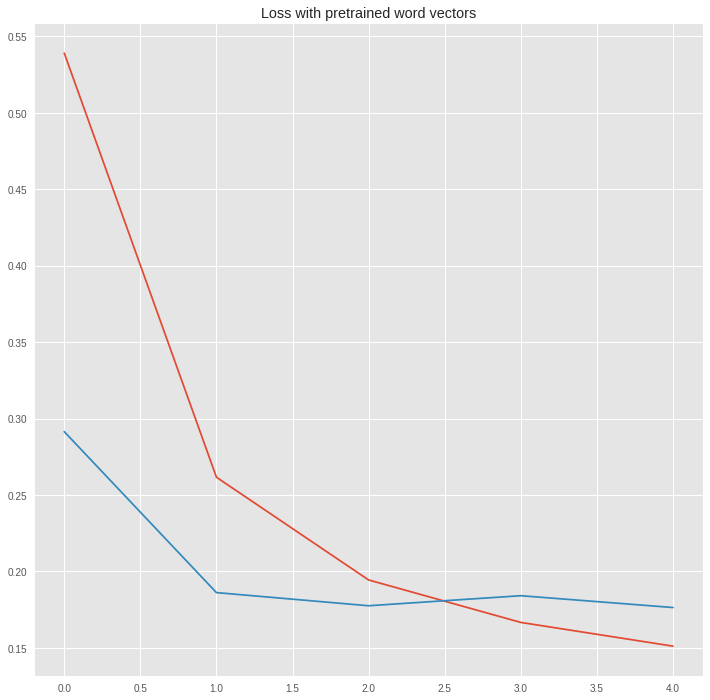

In [93]:
# Plotting the training process

history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.title("Loss with pretrained word vectors");
plt.show();

In [94]:
# How does it perform?

model.evaluate(X_test,y_test)

4957/4957 [==============================] - 1s 206us/step


[0.18051554963957622, 0.9315446372688213]

In [0]:
y_pred = model.predict(X_test)

In [96]:
print(y_pred)

[[6.2461096e-01 4.9253350e-01 6.0760356e-03]
 [6.3358921e-01 4.9448130e-01 4.6309927e-03]
 [1.0810854e-02 9.9326974e-01 1.1202999e-03]
 ...
 [1.7329675e-04 1.9547159e-03 9.9983132e-01]
 [4.8238765e-03 9.9098808e-01 2.9944456e-03]
 [6.4637102e-02 9.6171820e-01 3.2253759e-03]]


In [0]:
from sklearn.metrics import classification_report

In [98]:
cr_test = np.argmax(y_test, axis=1)
cr_pred = np.argmax(y_pred, axis=1)

print(classification_report(cr_test, cr_pred))

             precision    recall  f1-score   support

          0       0.52      0.29      0.37       293
          1       0.92      0.96      0.94      3850
          2       0.85      0.84      0.84       814

avg / total       0.89      0.90      0.89      4957



In [122]:
pd.crosstab(cr_test,cr_pred)

col_0,0,1,2
row_0,,,
0,579,742,109
1,201,18758,231
2,31,322,3810


In [0]:
hatespeech['pred'] = np.argmax(model.predict(X), axis=1)

In [120]:
hatespeech[(hatespeech['class'] == 0) & (hatespeech['pred'] == 2)]['tweet'].iloc[30]

"@klejdys He may be 'hustlin' but he studied Critical (Race) Theory and 'my people' Holder is getting his 'revenge.' They hate whitey."

In [121]:
cr_test = np.argmax(y, axis=1)
cr_pred = np.argmax(model.predict(X), axis=1)

print(classification_report(cr_test, cr_pred))

             precision    recall  f1-score   support

          0       0.71      0.40      0.52      1430
          1       0.95      0.98      0.96     19190
          2       0.92      0.92      0.92      4163

avg / total       0.93      0.93      0.93     24783



#### Great material

**Text generation with RNNs**

easier:
https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

more advanced:
https://medium.com/@david.campion/text-generation-using-bidirectional-lstm-and-doc2vec-models-1-3-8979eb65cb3a

**Explainable NLP**

http://nlp.town/blog/understanding-deeplearning-models-nlp/